In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16.0, 9.0)

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.graphics.tsaplots import plot_pacf

import warnings

This is a simplified replication of Dr. Brownlee's blog post at https://machinelearningmastery.com/time-series-forecast-case-study-python-monthly-armed-robberies-boston/.

# Data loading and preparing

In [2]:
df = pd.read_csv('robberies.csv',parse_dates=True)

In [3]:
df

Month  Robberies
0    1966-01         41
1    1966-02         39
2    1966-03         50
3    1966-04         40
4    1966-05         43
..       ...        ...
113  1975-06        316
114  1975-07        398
115  1975-08        394
116  1975-09        431
117  1975-10        431

[118 rows x 2 columns]

In [4]:
df['Month'] = pd.to_datetime(df['Month'])

In [5]:
df

Month  Robberies
0   1966-01-01         41
1   1966-02-01         39
2   1966-03-01         50
3   1966-04-01         40
4   1966-05-01         43
..         ...        ...
113 1975-06-01        316
114 1975-07-01        398
115 1975-08-01        394
116 1975-09-01        431
117 1975-10-01        431

[118 rows x 2 columns]

In [6]:
df.set_index('Month',inplace=True)

<AxesSubplot:xlabel='Month'>

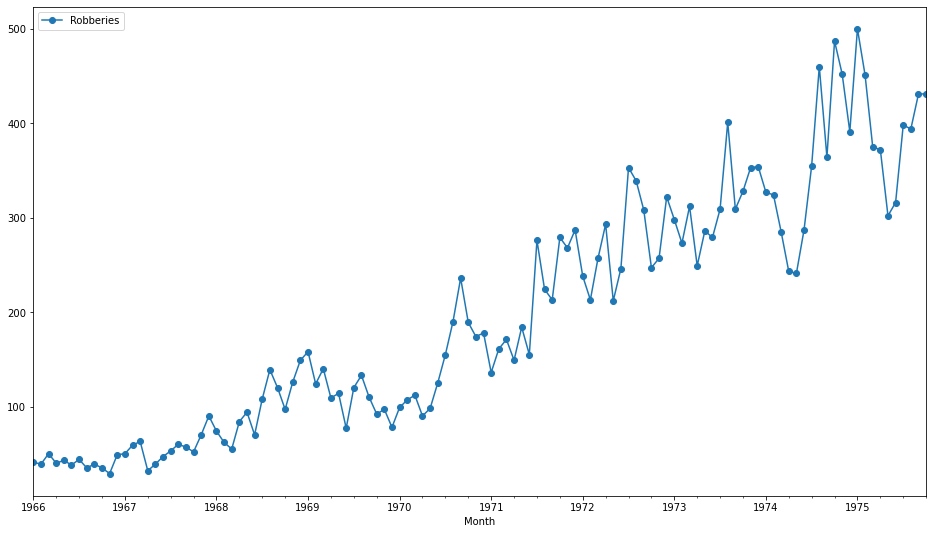

In [7]:
df.plot(style='o-')

# Train, validtion, test split

Strategy:
- 用1975的数据作为 test set, 前面的为training set
- training里面，前50%作为初始的training, 做one-step prediction (比如这个时间点为t). 接着把t时刻的真实数据拿进来，继续对t+1做预测。
- 注意这里不用滚动窗口。每步做预测时，都用全部的历史数据来训练模型

In [8]:
test = df['1975':].copy()

In [9]:
test

Robberies
Month                
1975-01-01        500
1975-02-01        451
1975-03-01        375
1975-04-01        372
1975-05-01        302
1975-06-01        316
1975-07-01        398
1975-08-01        394
1975-09-01        431
1975-10-01        431

In [10]:
train = df[:'1974'].copy()

In [11]:
train

Robberies
Month                
1966-01-01         41
1966-02-01         39
1966-03-01         50
1966-04-01         40
1966-05-01         43
...               ...
1974-08-01        460
1974-09-01        364
1974-10-01        487
1974-11-01        452
1974-12-01        391

[108 rows x 1 columns]

In [12]:
train_size = int(train.shape[0] * 0.5)
train_tr, train_val = train[0:train_size], train[train_size:]

In [13]:
train_tr

Robberies
Month                
1966-01-01         41
1966-02-01         39
1966-03-01         50
1966-04-01         40
1966-05-01         43
1966-06-01         38
1966-07-01         44
1966-08-01         35
1966-09-01         39
1966-10-01         35
1966-11-01         29
1966-12-01         49
1967-01-01         50
1967-02-01         59
1967-03-01         63
1967-04-01         32
1967-05-01         39
1967-06-01         47
1967-07-01         53
1967-08-01         60
1967-09-01         57
1967-10-01         52
1967-11-01         70
1967-12-01         90
1968-01-01         74
1968-02-01         62
1968-03-01         55
1968-04-01         84
1968-05-01         94
1968-06-01         70
1968-07-01        108
1968-08-01        139
1968-09-01        120
1968-10-01         97
1968-11-01        126
1968-12-01        149
1969-01-01        158
1969-02-01        124
1969-03-01        140
1969-04-01        109
1969-05-01        114
1969-06-01         77
1969-07-01        120
1969-08-01        133
1969-09-01        110
1969-10-01         92
1969-11-01         97
1969-12-01         78
1970-01-01         99
1970-02-01        107
1970-03-01        112
1970-04-01         90
1970-05-01         98
1970-06-01        125

In [14]:
train_val

Robberies
Month                
1970-07-01        155
1970-08-01        190
1970-09-01        236
1970-10-01        189
1970-11-01        174
1970-12-01        178
1971-01-01        136
1971-02-01        161
1971-03-01        171
1971-04-01        149
1971-05-01        184
1971-06-01        155
1971-07-01        276
1971-08-01        224
1971-09-01        213
1971-10-01        279
1971-11-01        268
1971-12-01        287
1972-01-01        238
1972-02-01        213
1972-03-01        257
1972-04-01        293
1972-05-01        212
1972-06-01        246
1972-07-01        353
1972-08-01        339
1972-09-01        308
1972-10-01        247
1972-11-01        257
1972-12-01        322
1973-01-01        298
1973-02-01        273
1973-03-01        312
1973-04-01        249
1973-05-01        286
1973-06-01        279
1973-07-01        309
1973-08-01        401
1973-09-01        309
1973-10-01        328
1973-11-01        353
1973-12-01        354
1974-01-01        327
1974-02-01        324
1974-03-01        285
1974-04-01        243
1974-05-01        241
1974-06-01        287
1974-07-01        355
1974-08-01        460
1974-09-01        364
1974-10-01        487
1974-11-01        452
1974-12-01        391

# Benchmark model

用上一期的数据作为下一期的预测

In [15]:
y_preds_benchmark = []
history = train_tr['Robberies'].tolist()
for i in range(train_val.shape[0]):
    y_pred = history[-1]
    y_true = train_val.iloc[i].values[0]
    y_preds_benchmark.append(y_pred)
    history.append(y_true)
    print(f"Prediction: {y_pred}; True value: {y_true}")
print("RMSE:", np.sqrt(mean_squared_error(train_val['Robberies'],y_preds_benchmark)))

Prediction: 125; True value: 155
Prediction: 155; True value: 190
Prediction: 190; True value: 236
Prediction: 236; True value: 189
Prediction: 189; True value: 174
Prediction: 174; True value: 178
Prediction: 178; True value: 136
Prediction: 136; True value: 161
Prediction: 161; True value: 171
Prediction: 171; True value: 149
Prediction: 149; True value: 184
Prediction: 184; True value: 155
Prediction: 155; True value: 276
Prediction: 276; True value: 224
Prediction: 224; True value: 213
Prediction: 213; True value: 279
Prediction: 279; True value: 268
Prediction: 268; True value: 287
Prediction: 287; True value: 238
Prediction: 238; True value: 213
Prediction: 213; True value: 257
Prediction: 257; True value: 293
Prediction: 293; True value: 212
Prediction: 212; True value: 246
Prediction: 246; True value: 353
Prediction: 353; True value: 339
Prediction: 339; True value: 308
Prediction: 308; True value: 247
Prediction: 247; True value: 257
Prediction: 257; True value: 322
Prediction

# ARIMA Model

## Stationarity test

In [16]:
train_diff = train.diff()

In [17]:
train_diff

Robberies
Month                
1966-01-01        NaN
1966-02-01       -2.0
1966-03-01       11.0
1966-04-01      -10.0
1966-05-01        3.0
...               ...
1974-08-01      105.0
1974-09-01      -96.0
1974-10-01      123.0
1974-11-01      -35.0
1974-12-01      -61.0

[108 rows x 1 columns]

In [18]:
adf_result = adfuller(train_diff.dropna())

In [19]:
adf_result

(-4.202777701708447,
 0.0006518027393817898,
 11,
 95,
 {'1%': -3.5011373281819504,
  '5%': -2.8924800524857854,
  '10%': -2.5832749307479226},
 941.0530200833376)

In [20]:
def print_adf(result):
    print(f"ADF statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("Reject NULL (there is unit root)")
    else:
        print("Can't reject NULL (there is unit root)")

In [21]:
print_adf(adf_result)

ADF statistic: -4.202777701708447
p-value: 0.0006518027393817898
Reject NULL (there is unit root)


In [22]:
print_adf(adfuller(train))

ADF statistic: 0.5716187740558692
p-value: 0.986894783782641
Can't reject NULL (there is unit root)


## Order of lags in AR and MA

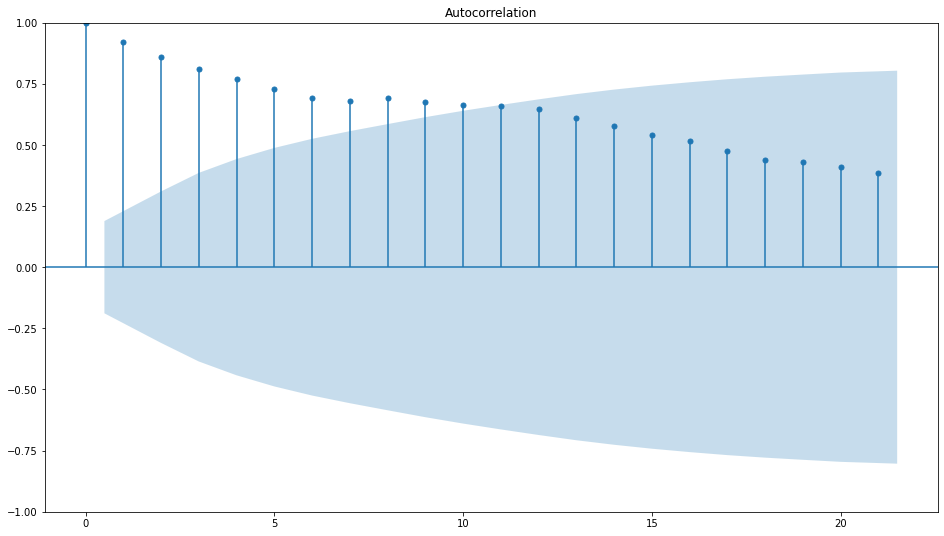

In [23]:
plot_acf(train);

In [24]:
plot_pacf(train);

/Users/Bert/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


猜测是AR过程

## Fit ARIMA model and predict on the validation set

In [25]:
model = ARIMA(history, order=(1,1,1))
model.fit().forecast()[0]

394.40500371684914

In [26]:
history = train_tr['Robberies'].tolist()
y_preds_arima = []
for i in range(train_val.shape[0]):
    model = ARIMA(history, order=(2,1,0))
    y_pred = model.fit().forecast()[0]
    y_true = train_val.iloc[i].values[0]
    y_preds_arima.append(y_pred)
    history.append(y_true)
    print(f"Prediction: {y_pred}; True value: {y_true}")
print("RMSE:", np.sqrt(mean_squared_error(train_val['Robberies'],y_preds_arima)))

Prediction: 116.13826048542691; True value: 155
Prediction: 142.22047852696886; True value: 190
Prediction: 180.79144132346119; True value: 236
Prediction: 232.47300735447297; True value: 189
Prediction: 184.54029964964909; True value: 174
Prediction: 184.243214380366; True value: 178
Prediction: 180.5685351227171; True value: 136
Prediction: 138.0211852126305; True value: 161
Prediction: 165.21196494222835; True value: 171
Prediction: 165.86612915600122; True value: 149
Prediction: 149.40697000264058; True value: 184
Prediction: 183.339732939413; True value: 155
Prediction: 154.18980995807627; True value: 276
Prediction: 245.9601394634167; True value: 224
Prediction: 237.58812484317738; True value: 213
Prediction: 220.7098717027588; True value: 279
Prediction: 258.41934299064087; True value: 268
Prediction: 261.43013110328536; True value: 287
Prediction: 282.2282345371878; True value: 238
Prediction: 252.2338479037592; True value: 213
Prediction: 226.40250393407; True value: 257
Predi

## Grid Search d, p, q

In [27]:
def eval_arima(X, train_size_percent=0.5, arima_order=(0,0,0)):
    """
    X: the input data, should be an np.array or list
    train_size: the training sample size
    arima_order: d, p, q
    """
    train_size = int(len(X) * train_size_percent)
    train, val = X[0:train_size], X[train_size:]
    history = train
    y_preds_arima = []
    
    for i in range(train_val.shape[0]):
        model = ARIMA(history, order=arima_order)
        y_pred = model.fit().forecast()[0]
        y_true = train_val.iloc[i].values[0]
        y_preds_arima.append(y_pred)
        history.append(y_true)
    rmse = np.sqrt(mean_squared_error(train_val['Robberies'],y_preds_arima))
    return rmse

In [28]:
X = train['Robberies'].tolist()
eval_arima(X=X, arima_order=(1,1,1))

/Users/Bert/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/Bert/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Bert/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/Bert/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressiv

50.11594994193283

In [29]:
def grid_search_arima(X, p_values, d_values, q_values):
    best_rmse, best_config = np.inf, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                arima_order = (p,d,q)
                # try:
                rmse = eval_arima(X, arima_order=arima_order)
                if rmse < best_rmse:
                    best_rmse, best_config = rmse, arima_order
                print(f"ARIMA{arima_order} RMSE={rmse}")
                # except:
                #     continue
    print(f"Best ARIMA{best_config}, RMSE={best_rmse}")

In [30]:
p_values = range(4)
d_values = range(3)
q_values = range(4)
warnings.filterwarnings("ignore")
grid_search_arima(X, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=160.71163903778185
ARIMA(0, 0, 1) RMSE=101.61986716464376
ARIMA(0, 0, 2) RMSE=93.12741468295458
ARIMA(0, 0, 3) RMSE=71.49166373013114
ARIMA(0, 1, 0) RMSE=52.11596755385123
ARIMA(0, 1, 1) RMSE=50.775787669920796
ARIMA(0, 1, 2) RMSE=50.93725482053231
ARIMA(0, 1, 3) RMSE=51.880726548734636
ARIMA(0, 2, 0) RMSE=82.46256165117696
ARIMA(0, 2, 1) RMSE=52.271196282283356
ARIMA(0, 2, 2) RMSE=50.64852230733425
ARIMA(0, 2, 3) RMSE=50.14259925865152
ARIMA(1, 0, 0) RMSE=53.151688771366274
ARIMA(1, 0, 1) RMSE=51.585341465415254
ARIMA(1, 0, 2) RMSE=51.705579952974375
ARIMA(1, 0, 3) RMSE=52.73052278297684
ARIMA(1, 1, 0) RMSE=51.07077652138068
ARIMA(1, 1, 1) RMSE=50.11594994193283
ARIMA(1, 1, 2) RMSE=51.45246359785154
ARIMA(1, 1, 3) RMSE=51.97828794776939
ARIMA(1, 2, 0) RMSE=69.53945486612814
ARIMA(1, 2, 1) RMSE=51.09436611584482
ARIMA(1, 2, 2) RMSE=51.89458499366305
ARIMA(1, 2, 3) RMSE=50.61678461349365
ARIMA(2, 0, 0) RMSE=52.190105991342875
ARIMA(2, 0, 1) RMSE=51.93094093857045
ARI

## Forecast in the test set

In [31]:
test

Robberies
Month                
1975-01-01        500
1975-02-01        451
1975-03-01        375
1975-04-01        372
1975-05-01        302
1975-06-01        316
1975-07-01        398
1975-08-01        394
1975-09-01        431
1975-10-01        431

In [32]:
train

Robberies
Month                
1966-01-01         41
1966-02-01         39
1966-03-01         50
1966-04-01         40
1966-05-01         43
...               ...
1974-08-01        460
1974-09-01        364
1974-10-01        487
1974-11-01        452
1974-12-01        391

[108 rows x 1 columns]

In [33]:
history = train['Robberies'].tolist()
arima_order = (1,1,1)
y_preds_arima = []

for i in range(len(test)):
    model = ARIMA(history, order=arima_order)
    y_pred = model.fit().forecast()[0]
    y_true = test.iloc[i].values[0]
    y_preds_arima.append(y_pred)
    history.append(y_true)
    print(f"Prediction: {y_pred}; True value: {y_true}")
rmse = np.sqrt(mean_squared_error(test['Robberies'],y_preds_arima))
print(f"RMSE on the test set: {rmse}")

Prediction: 394.40500371684914; True value: 500
Prediction: 468.9610412105832; True value: 451
Prediction: 450.6553162745826; True value: 375
Prediction: 398.74690990073833; True value: 372
Prediction: 388.37982274649255; True value: 302
Prediction: 335.0354517150133; True value: 316
Prediction: 336.1648920420705; True value: 398
Prediction: 387.5746420824057; True value: 394
Prediction: 387.3110651268368; True value: 431
Prediction: 414.0072019080435; True value: 431
RMSE on the test set: 56.3898860868204
